In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# The Data

In [2]:
!git clone https://github.com/OmdenaAI/milan-chapter-agrifoods.git

Cloning into 'milan-chapter-agrifoods'...
remote: Enumerating objects: 4214, done.
remote: Counting objects: 100% (230/230), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 4214 (delta 157), reused 183 (delta 133), pack-reused 3984
Receiving objects: 100% (4214/4214), 835.72 MiB | 17.04 MiB/s, done.
Resolving deltas: 100% (1150/1150), done.
Checking out files: 100% (172/172), done.


In [3]:
%cd /content/milan-chapter-agrifoods/src/tasks/task_4 Modeling

/content/milan-chapter-agrifoods/src/tasks/task_4 Modeling


In [4]:
%cd Image\ modelling

/content/milan-chapter-agrifoods/src/tasks/task_4 Modeling/Image modelling


In [5]:
import numpy as np
from pathlib import Path

path_to_histogram =  './data/histogram/histogram_all_full.npz'

with np.load(path_to_histogram) as hist:
    images = hist["output_image"]
    locations = hist["output_locations"]
    yields = hist["output_yield"]
    years = hist["output_year"]
    indices = hist["output_index"]

In [6]:

def _normalize(train_images, val_images):
        """
        Find the mean values of the bands in the train images. Use these values
        to normalize both the training and validation images.

        """
        mean = np.mean(train_images, axis=(0, 2, 3))

        train_images = (train_images.transpose(0, 2, 3, 1) - mean).transpose(0, 3, 1, 2)
        val_images = (val_images.transpose(0, 2, 3, 1) - mean).transpose(0, 3, 1, 2)

        return train_images, val_images


In [40]:
pred_years = 2019 #range(2019, 2020)


train_idx = np.nonzero(years < 2019)[0]
test_idx = np.nonzero(years == pred_years)[0]

train_images, test_images = _normalize(images[train_idx], images[test_idx])


In [8]:
from collections import defaultdict, namedtuple


print(
    f"Train set size: {train_idx.shape[0]}, Test set size: {test_idx.shape[0]}"
)

Data = namedtuple("Data", ["images", "yields", "locations", "indices", "years"])


Train set size: 486, Test set size: 73


In [41]:
import torch
time = 32
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_data = Data(
    images=torch.as_tensor(
        train_images[:, :, :time, :], device=device
    ).float(),
    yields=torch.as_tensor(yields[train_idx], device=device)
    .float()
    .unsqueeze(1),
    locations=torch.as_tensor(locations[train_idx]),
    indices=torch.as_tensor(indices[train_idx]),
    years=torch.as_tensor(years[train_idx]),
)

test_data = Data(
    images=torch.as_tensor(
        test_images[:, :, :time, :], device=device
    ).float(),
    yields=torch.as_tensor(yields[test_idx], device=device)
    .float()
    .unsqueeze(1),
    locations=torch.as_tensor(locations[test_idx]),
    indices=torch.as_tensor(indices[test_idx]),
    years=torch.as_tensor(years[test_idx]),
)


In [42]:
from torch.utils.data import TensorDataset, DataLoader, random_split

train_images =train_data.images
train_yields =train_data.yields
train_steps = 10000
batch_size = 4
starter_learning_rate = 0.001

total_size = train_images.shape[0]
# validation set (10%)."
val_size = total_size // 10
train_size = total_size - val_size
print(
    f"After split, training on {train_size} examples, "
    f"validating on {val_size} examples"
)
train_dataset, val_dataset = random_split(
    TensorDataset(train_images, train_yields), (train_size, val_size)
)

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

test_dataset = TensorDataset(
    test_data.images, test_data.yields, test_data.locations, test_data.indices, test_data.years
)

test_dataloader = DataLoader(test_dataset, batch_size=1)

num_epochs = int(train_steps / (train_images.shape[0] / batch_size))
print(f"Training for {num_epochs} epochs")

train_scores = defaultdict(list)
val_scores = defaultdict(list)

step_number = 0
min_loss = np.inf
# best_state = self.model.state_dict()

After split, training on 438 examples, validating on 48 examples
Training for 82 epochs


In [49]:
def get_predi_year(pred_years):
  Tdata={}
  if isinstance(pred_years, int)  :
    test_idx = np.nonzero(years == pred_years)[0]

    train_images, test_images = _normalize(images[train_idx], images[test_idx])

    test_data = Data(
        images=torch.as_tensor(
            test_images[:, :, :time, :], device=device
        ).float(),
        yields=torch.as_tensor(yields[test_idx], device=device)
        .float()
        .unsqueeze(1),
        locations=torch.as_tensor(locations[test_idx]),
        indices=torch.as_tensor(indices[test_idx]),
        years=torch.as_tensor(years[test_idx]),
    )

    test_dataset = TensorDataset(
        test_data.images, test_data.yields, test_data.locations, test_data.indices, test_data.years
    )

    test_dataloader = DataLoader(test_dataset, batch_size=1)
    return test_dataloader
  else:
    for pred_year in pred_years:
      test_idx = np.nonzero(years == pred_year)[0]

      train_images, test_images = _normalize(images[train_idx], images[test_idx])

      test_data = Data(
          images=torch.as_tensor(
              test_images[:, :, :time, :], device=device
          ).float(),
          yields=torch.as_tensor(yields[test_idx], device=device)
          .float()
          .unsqueeze(1),
          locations=torch.as_tensor(locations[test_idx]),
          indices=torch.as_tensor(indices[test_idx]),
          years=torch.as_tensor(years[test_idx]),
      )

      test_dataset = TensorDataset(
          test_data.images, test_data.yields, test_data.locations, test_data.indices, test_data.years
      )

      test_dataloader = DataLoader(test_dataset, batch_size=1)
      Tdata[pred_year] = test_dataloader
    return Tdata
# test_dataloader=get_predi_year(pred_years=2019)

# The Models 

In [11]:
import torchvision
from torch import nn
class Model_(nn.Module):

    def __init__(self):
        super(Model_, self).__init__()

        #===================================>
        self.resnet = torchvision.models.resnet18(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(9, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)        
        self.fc_in_features = self.resnet.fc.in_features        
        self.resnet = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))
        #===================================>
        self.fc = nn.Sequential(
            nn.Linear(self.fc_in_features , 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
        )

        self.sigmoid = nn.Sigmoid()


        self.resnet.apply(self.init_weights)

        self.fc.apply(self.init_weights)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)

    def forward_once(self, x):
        output = self.resnet(x)
        output = output.view(output.size()[0], -1)
        return output

    def forward(self, input1):
        output = self.forward_once(input1)


        output = self.fc(output)

        
        return output

In [12]:
import torchvision
from torch import nn
class Model_2(nn.Module):

    def __init__(self):
        super(Model_2, self).__init__()

        self.cnn1= nn.Conv2d(9,32, kernel_size=(3,3),padding=(1,1))
        self.cnn2= nn.Conv2d(32,3,kernel_size=(1,1),padding=(1,1))
        #===================================>
        self.resnet = torchvision.models.resnet18(pretrained=True)
        # self.resnet = torchvision.models.resnet50(pretrained=True)
        self.fc_in_features = self.resnet.fc.in_features        
        self.resnet = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))
        #===================================>
        self.fc = nn.Sequential(
            nn.Dropout2d(inplace=True),
            nn.Linear(self.fc_in_features, 256),
            nn.BatchNorm1d(256),
            nn.Dropout2d(inplace=True),
            nn.Linear(256, 1),
        )

        # self.resnet.apply(self.init_weights)
        self.cnn1.apply(self.initialize_weights)
        self.cnn2.apply(self.initialize_weights)
        self.fc.apply(self.initialize_weights)

    def initialize_weights(self,m):
      if isinstance(m, nn.Conv2d):
          nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
          if m.bias is not None:
              nn.init.constant_(m.bias.data, 0)
      elif isinstance(m, nn.BatchNorm2d):
          nn.init.constant_(m.weight.data, 1)
          nn.init.constant_(m.bias.data, 0)
      elif isinstance(m, nn.Linear):
          nn.init.kaiming_uniform_(m.weight.data)
          nn.init.constant_(m.bias.data, 0)       
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)

    def forward_once(self, x):
        x   = self.cnn1(x)
        x   = self.cnn2(x)
        x   = self.resnet(x)
        x   = x.view(x.size()[0], -1)
        return x

    def forward(self, input1):
        output = self.forward_once(input1)

        output = self.fc(output)
        
        return output

In [13]:
import torchvision
from torch import nn
!pip install vit-pytorch
from vit_pytorch.crossformer import CrossFormer
class Model_transformer(nn.Module):

    def __init__(self):
        super(Model_transformer, self).__init__()
        self.modelName='Model_transformer'

        self.transformer=model = CrossFormer(
              num_classes = 1,                # number of output classes
              dim = (64, 128, 256, 512),         # dimension at each stage
              depth = (2, 2, 8, 2),              # depth of transformer at each stage
              global_window_size = (8, 4, 2, 1), # global window sizes at each stage
              local_window_size = 7,             # local window size (can be customized for each stage, but in paper, held constant at 7 for all stages)
          )    
        self.cnn1= nn.Conv2d(9,3, kernel_size=(3,3),padding=(1,1))
        # self.cnn2_depth= nn.Conv2d(32,3,kernel_size=(1,1),padding=(1,1))

        self.cnn1.apply(self.initialize_weights)
        # #===================================>
        # self.fc = nn.Sequential(
        #     nn.Dropout2d(inplace=True),
        #     nn.Linear(self.fc_in_features, 256),
        #     nn.BatchNorm1d(256),
        #     nn.Dropout2d(inplace=True),
        #     nn.Linear(256, 1),
        # )


        # self.fc.apply(self.initialize_weights)
    def initialize_weights(self,m):
      if isinstance(m, nn.Conv2d):
          nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
          if m.bias is not None:
              nn.init.constant_(m.bias.data, 0)
      elif isinstance(m, nn.BatchNorm2d):
          nn.init.constant_(m.weight.data, 1)
          nn.init.constant_(m.bias.data, 0)
      elif isinstance(m, nn.Linear):
          nn.init.kaiming_uniform_(m.weight.data)
          nn.init.constant_(m.bias.data, 0)       
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)

    def forward_once(self, x):
        x   = self.cnn1(x)
        x   = self.transformer(x)
        return x

    def forward(self, input1):
        output = self.forward_once(input1)

        # output = self.fc(output)
        
        return output

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76 kB 5.3 MB/s 
     |████████████████████████████████| 41 kB 497 kB/s 


In [14]:
import torchvision
from torch import nn
!pip install vit-pytorch
from vit_pytorch.crossformer import CrossFormer
class Model_transformer2(nn.Module):

    def __init__(self):
        super(Model_transformer, self).__init__()
        self.modelName='Model_transformer2'

        self.transformer= CrossFormer(
              num_classes = 16,                # number of output classes
              dim = (64, 128, 256, 512),         # dimension at each stage
              depth = (2, 2, 8, 2),              # depth of transformer at each stage
              global_window_size = (8, 4, 2, 1), # global window sizes at each stage
              local_window_size = 7,             # local window size (can be customized for each stage, but in paper, held constant at 7 for all stages)
          )    
        self.cnn1= nn.Conv2d(9,3, kernel_size=(3,3),padding=(1,1))
        # self.cnn2_depth= nn.Conv2d(32,3,kernel_size=(1,1),padding=(1,1))

        self.cnn1.apply(self.initialize_weights)
        # #===================================>
        self.fc = nn.Sequential(
            nn.Dropout2d(inplace=True),
            nn.Linear(16, 8),
            nn.Dropout2d(inplace=True),
            nn.Linear(8, 1),
        )


        self.fc.apply(self.initialize_weights)
    def initialize_weights(self,m):
      if isinstance(m, nn.Conv2d):
          nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
          if m.bias is not None:
              nn.init.constant_(m.bias.data, 0)
      elif isinstance(m, nn.BatchNorm2d):
          nn.init.constant_(m.weight.data, 1)
          nn.init.constant_(m.bias.data, 0)
      elif isinstance(m, nn.Linear):
          nn.init.kaiming_uniform_(m.weight.data)
          nn.init.constant_(m.bias.data, 0)       
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)

    def forward_once(self, x):
        x   = self.cnn1(x)
        x   = self.transformer(x)
        return x

    def forward(self, input1):
        output = self.forward_once(input1)

        output = self.fc(output)
        
        return output

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

# masks= torch.ones((1,9,32,32))
# ups = nn.UpsamplingNearest2d( size=(224,224))
# out=ups(masks)
# out.shape

torch.Size([1, 9, 224, 224])

In [ ]:
# mmodel=Model_transformer()
# mmodel(out).item()

0.5368812680244446

In [ ]:
# for id,data in enumerate(test_dataloader):
#     # get the inputs
#     the_tensor, labels = data[0],data[1]
#     print(labels)

#     if id>3:
#       break

tensor([[58.7970]], device='cuda:0')
tensor([[43.8031]], device='cuda:0')
tensor([[26.]], device='cuda:0')
tensor([[47.1855]], device='cuda:0')
tensor([[34.7500]], device='cuda:0')


# Training and validation

In [15]:
import torch.nn.functional as F


def l1_l2_loss(pred, true, l1_weight, scores_dict):
    """
    Regularized MSE loss; l2 loss with l1 loss too.

    Parameters
    ----------
    
    Returns
    ----------
    loss: the regularized mse loss
    """
    loss = F.mse_loss(pred, true)

    scores_dict["l2"].append(loss.item())

    if l1_weight > 0:
        l1 = F.l1_loss(pred, true)
        loss += l1
        scores_dict["l1"].append(l1.item())
    scores_dict["loss"].append(loss.item())

    return loss, scores_dict

In [16]:
!pip install tqdm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
from torch import optim
import pandas as pd
from tqdm import tqdm

use_gpu =torch.cuda.is_available()
criterion = nn.MSELoss()

def validation(Model,val_dataloader,is_transformer=False):
    val_loss=[]
    target=[]
    running_loss=0.0
    counter=0
    Model.eval()
    for data in tqdm(val_dataloader)  :
        counter+=1
        input1, labels = data
        
        # wrap them in Variable
        if use_gpu:
            input1 = Variable(input1.cuda())

            labels = Variable(labels.cuda())
        else:
            input1,  labels = Variable(input1),  Variable(labels)
        if is_transformer:
              md=nn.UpsamplingNearest2d(size=(224,224))
              input1=md(input1)
        # forward
        outputs = Model(input1)  

        loss = criterion(outputs, labels)


        # statistics
        running_loss += loss.item()

    epoch_loss = running_loss / counter

    return epoch_loss 
def teste(Model,test_dataloader,is_transformer=False):
    # fig = plt.figure()
    val_loss=[]
    target=[]
    running_loss=0.0
    counter=0
    Model.eval()
    for id,data in enumerate(test_dataloader)  :
        counter+=1
        input1, labels = data[0],data[1]
        
        input1, labels = data[0].to(device),data[1].to(device)

        if is_transformer:
              md=nn.UpsamplingNearest2d(size=(224,224))
              input1=md(input1)
        # forward
        outputs = Model(input1)  

        loss = criterion(outputs, labels)


        # statistics
        running_loss += loss.item()

    epoch_loss = running_loss / counter

    return epoch_loss   
def training_step(MODEL,
                  train_dataloader,
                  val_dataloader,
                  test_dataloader,                  
                  num_epochs=10,
                  freqq=10,
                  model_name='reg_resnet',
                  root_save='./content/',
                  is_transformer=True):

  criterion = nn.MSELoss()
  model_s=MODEL
  use_gpu =torch.cuda.is_available()

  
  if use_gpu:

      model_s = model_s.cuda()

  optimizer = optim.Adam(model_s.parameters(), lr=1e-3, weight_decay=0.0005)

  # optimizer=optim.Adam(model.parameters(),lr=3e-4,weight_decay=6e-5)
  scheduler = StepLR(optimizer, step_size=500, gamma=0.7)
  # num_epochs=100
  train_loss=[]
  val_loss = []
  test_loss =[]
  oldLoss=np.Inf
  prefixe =''
  for epoch in range(num_epochs+1):


      # Each epoch has a training and validation phase

      running_train_scores = defaultdict(list)
      l1_weight = 0
      running_loss = 0.0
      # running_corrects = 0
      counter=0
      # Iterate over data.
      for id,data in enumerate(train_dataloader):
          # get the inputs
          input1, labels = data
          counter=counter+1
          # wrap them in Variable
          input1, labels = data[0].to(device),data[1].to(device)


          # zero the parameter gradients
          optimizer.zero_grad()

          # forward
          if is_transformer:
              md=nn.UpsamplingNearest2d(size=(224,224))
              input1=md(input1)
          outputs = model_s(input1)
          loss = criterion(outputs, labels)
          loss.backward()

          optimizer.step()

          running_loss += loss.item()
        

      epoch_loss = running_loss / counter
      train_loss.append(epoch_loss)
      scheduler.step()

      if epoch %freqq ==0 :
        loss_val=validation(model_s,val_dataloader,is_transformer)

        if oldLoss>loss_val and counter>0:
            oldLoss=loss_val
            Models=model_s
            torch.save(Models.state_dict(), root_save+prefixe+model_name+'_.pt')
        
        # loss_val=validation(model_s,val_dataloader)
        val_loss.append(loss_val)
      # epoch_acc = running_corrects / dataset_sizes[phase]
        df_train= pd.DataFrame(data=train_loss)
        df_val= pd.DataFrame(data=val_loss)
        # df_test = pd.DataFrame(data=test_loss)
        df_train.to_csv(root_save +prefixe+model_name+'_train_loss.csv')
        df_val.to_csv(root_save +prefixe+model_name+'_val_loss.csv')

        tloss = teste(model_s,test_dataloader,is_transformer)
        test_loss.append(tloss)
        df_test= pd.DataFrame(data=test_loss)
        df_test.to_csv(root_save +prefixe+model_name+'_test_loss.csv')        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))

        print('-' * 10)        
        print('epoch: {} Loss: {:.4f}  val_loss: {} test_loss: {}'.format(
            epoch,epoch_loss,loss_val,tloss))
  # loss_val=validation(model_s,test_dataloader)
  # val_loss.append(loss_val)

  if oldLoss>loss_val and counter>0:
      oldLoss=loss_val
      Models=model_s
      torch.save(Models.state_dict(), root_save+prefixe+model_name+'_.pt')
    
  out={}
  out['test_loss']=test_loss
  out['val_loss']=val_loss
  out['train_loss'] = train_loss
  out['model'] = Models
  return out

In [ ]:
MODEL = Model_transformer()
mName= MODEL.modelName
result=training_step(result['model'],
                  train_dataloader,
                  val_dataloader,
                  test_dataloader,
                  num_epochs=1000,
                  freqq =100,
                  model_name=mName+'3',
                  is_transformer=True,
                  root_save='/content/drive/MyDrive/projet_python/model/')

# Evaluation

In [68]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_percentage_error
def plots(  predict, target,title=None,root='./'):
    """
    Function to save the loss and accuracy plots to disk.
    """

    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        predict, color='orange', linestyle='-', 
        label='Predict'
    )
    plt.plot(
        target, color='red', linestyle='-', 
        label='Target'
    )
    # plt.xlabel('No Sample')
    plt.ylabel('Yield')
    plt.title(title)
    plt.legend()
    plt.savefig(f"{root}{title}.png")
def visualize_predict_target(model,data,title=None,is_transformer=False,root='./'):
    images_so_far = 0
    # fig = plt.figure()
    predict=[]
    target=[]
    model.eval()
    for data in data:
        # get the inputs
        input1, labels = data[0].to(device),data[1].to(device)
        

        if is_transformer:
            md=nn.UpsamplingNearest2d(size=(224,224))
            input1=md(input1)
        # forward
        outputs = model(input1)
        # print(outputs.size())
        predict.append(outputs[0].item())
        target.append(labels[0].item())
    out= {}
    out['predict'] =predict
    out['target'] =target

    df= pd.DataFrame(data=out)

    # df_test = pd.DataFrame(data=test_loss)
    df.to_csv(f'{root}result_{title}.csv')

    # plots(  predict, target,title,root)
    score={}

    score['mse']=mean_squared_error( target,predict)
    score['rmse']=mean_squared_error( target,predict,squared=False)

    score['r2score']=r2_score( target,predict)
    score['mape'] =mean_absolute_percentage_error( target,predict)
    plots(  predict, target,title=f"year={title},rmse= {score['rmse']:.2f}",root=root)

    print(title,score)
    return predict, target,score

In [64]:
#load the best model
!gdown 1-Pu709O0ZSCcj4kVx2hRQP8ppprA5gr4 -O /content/
root_to_model ='/content/Model_transformer3_.pt'

Downloading...
From: https://drive.google.com/uc?id=1-Pu709O0ZSCcj4kVx2hRQP8ppprA5gr4
To: /content/Model_transformer3_.pt
100% 113M/113M [00:00<00:00, 302MB/s] 


In [ ]:
pred_years=range(2019,2022)
test_dataloaders=get_predi_year(pred_years)

MODEL = Model_transformer()
device= torch.device( 'cuda:0' if torch.cuda.is_available() else 'cpu' )

MODEL.load_state_dict( torch.load(root_to_model,map_location=device) )
MODEL.to(device)
for pred_year in pred_years:
  predict, target,metrics= visualize_predict_target(MODEL,test_dataloaders[pred_year],
                                                    is_transformer=True,title=str(pred_year),root='/content/')

# Results with transformer

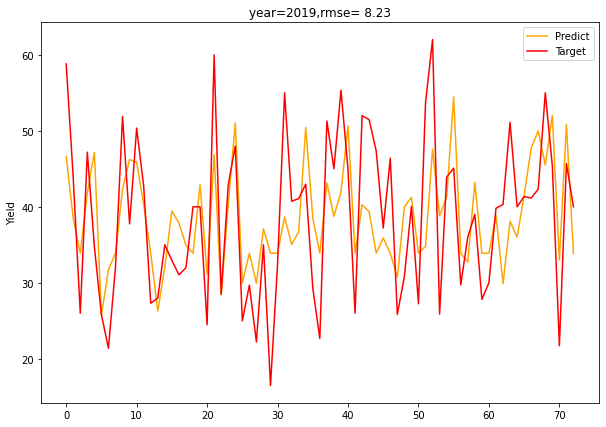


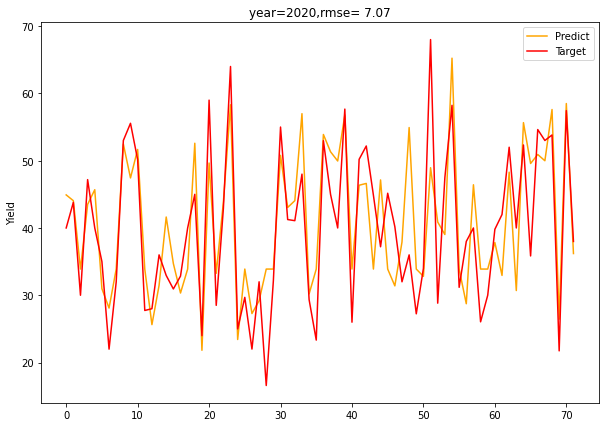

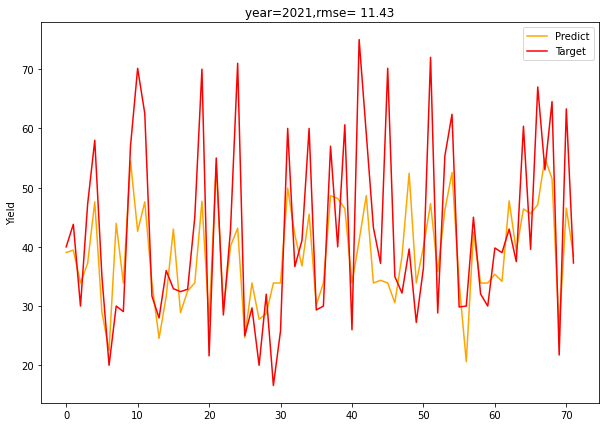